In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
import xgboost
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.shape

(39074, 16)

In [3]:
df.describe()

,id,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,is_rich
count,39074.000000,39074.000000,3.907400e+04,39074.000000,39074.000000,39074.000000,39074.000000,39074.000000
mean,29304.500000,38.694631,1.895940e+05,10.074576,1046.173875,87.393433,40.433895,0.239520
std,11279.836546,13.731323,1.058920e+05,2.572794,7302.852120,403.706583,12.373732,0.426796
min,9768.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,19536.250000,28.000000,1.174770e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,29304.500000,37.000000,1.781505e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,39072.750000,48.000000,2.371285e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,48841.000000,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39074 entries, 0 to 39073
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               39074 non-null  int64 
 1   age              39074 non-null  int64 
 2   workclass        39074 non-null  object
 3   fnlwgt           39074 non-null  int64 
 4   education        39074 non-null  object
 5   educational-num  39074 non-null  int64 
 6   marital-status   39074 non-null  object
 7   occupation       39074 non-null  object
 8   relationship     39074 non-null  object
 9   race             39074 non-null  object
 10  gender           39074 non-null  object
 11  capital-gain     39074 non-null  int64 
 12  capital-loss     39074 non-null  int64 
 13  hours-per-week   39074 non-null  int64 
 14  native-country   39074 non-null  object
 15  is_rich          39074 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 4.8+ MB


## Пропуски отсутствуют

In [5]:
df.isna().sum().sort_values(ascending=False)

id                 0
age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
is_rich            0
dtype: int64

## Разделение выборки на трецн и тест

In [6]:
X = df.drop(["is_rich", "id", "education", "marital-status"], axis=1)
y = df['is_rich']

In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)

## Работа с выбросами¶

In [8]:
def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    
    return boundaries
boundaries = calculate_outliers(train_x.age)
boundaries

(-2.0, 78.0)

In [9]:
is_outlier = (train_x.age < boundaries[0]) | (train_x.age > boundaries[1]) 
is_outlier.sum()

161

In [10]:
train_x.loc[is_outlier, 'age'] = int(boundaries[1])
is_outlier = (train_x.age < boundaries[0]) | (train_x.age > boundaries[1]) 
is_outlier.sum()

0

In [11]:
boundaries = calculate_outliers(test_x.age)
boundaries

(-0.5, 75.5)

In [12]:
is_outlier = (test_x.age < boundaries[0]) | (test_x.age > boundaries[1]) 
is_outlier.sum()

43

In [13]:
test_x.loc[is_outlier, 'age'] = int(boundaries[1])
is_outlier = (test_x.age < boundaries[0]) | (test_x.age > boundaries[1]) 
is_outlier.sum()

0

In [14]:
boundaries = calculate_outliers(train_x.fnlwgt)
boundaries

(-61738.125, 416372.875)

In [15]:
is_outlier = (train_x.fnlwgt < boundaries[0]) | (train_x.fnlwgt > boundaries[1])
is_outlier.sum()

1005

In [16]:
train_x.loc[is_outlier, 'fnlwgt'] = int(boundaries[1])
is_outlier = (train_x.fnlwgt < boundaries[0]) | (train_x.fnlwgt > boundaries[1]) 
is_outlier.sum()

0

In [17]:
boundaries = calculate_outliers(test_x.fnlwgt)
boundaries

(-64941.125, 418967.875)

In [18]:
is_outlier = (test_x.fnlwgt < boundaries[0]) | (test_x.fnlwgt > boundaries[1])
is_outlier.sum()

159

In [19]:
test_x.loc[is_outlier, 'fnlwgt'] = int(boundaries[1])
is_outlier = (test_x.fnlwgt < boundaries[0]) | (test_x.fnlwgt > boundaries[1]) 
is_outlier.sum()

0

In [20]:
boundaries = calculate_outliers(train_x["hours-per-week"])
boundaries

(32.5, 52.5)

In [21]:
is_outlier = (train_x["hours-per-week"] < boundaries[0]) | (train_x["hours-per-week"] > boundaries[1])
is_outlier.sum()

9136

In [22]:
train_x.loc[is_outlier, 'hours-per-week'] = int(boundaries[1])
is_outlier = (train_x["hours-per-week"] < boundaries[0]) | (train_x["hours-per-week"] > boundaries[1]) 
is_outlier.sum()

0

In [23]:
boundaries = calculate_outliers(test_x["hours-per-week"])
boundaries

(32.5, 52.5)

In [24]:
is_outlier = (test_x["hours-per-week"] < boundaries[0]) | (test_x["hours-per-week"] > boundaries[1])
is_outlier.sum()

1606

In [25]:
test_x.loc[is_outlier, 'hours-per-week'] = int(boundaries[1])
is_outlier = (test_x["hours-per-week"] < boundaries[0]) | (test_x["hours-per-week"] > boundaries[1]) 
is_outlier.sum()

0

## Создание частотных переменных

In [26]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33212 entries, 16689 to 20736
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              33212 non-null  int64 
 1   workclass        33212 non-null  object
 2   fnlwgt           33212 non-null  int64 
 3   educational-num  33212 non-null  int64 
 4   occupation       33212 non-null  object
 5   relationship     33212 non-null  object
 6   race             33212 non-null  object
 7   gender           33212 non-null  object
 8   capital-gain     33212 non-null  int64 
 9   capital-loss     33212 non-null  int64 
 10  hours-per-week   33212 non-null  int64 
 11  native-country   33212 non-null  object
dtypes: int64(6), object(6)
memory usage: 3.3+ MB


In [27]:
fe1 = train_x.groupby("workclass").size()/len(train_x)
train_x["workclass_freq"] = train_x["workclass"].map(fe1)
fe4 = train_x.groupby("relationship").size()/len(train_x)
train_x["relationship_freq"] = train_x["relationship"].map(fe4)
fe5 = train_x.groupby("gender").size()/len(train_x)
train_x["gender_freq"] = train_x["gender"].map(fe5)
fe5 = train_x.groupby("occupation").size()/len(train_x)
train_x["occupation_freq"] = train_x["occupation"].map(fe5)
fe6 = train_x.groupby("native-country").size()/len(train_x)
train_x["native-country_freq"] = train_x["native-country"].map(fe6)
fe7 = train_x.groupby("race").size()/len(train_x)
train_x["race-country_freq"] = train_x["race"].map(fe7)

In [28]:
fe1 = test_x.groupby("workclass").size()/len(test_x)
test_x["workclass_freq"] = test_x["workclass"].map(fe1)
fe4 = test_x.groupby("relationship").size()/len(test_x)
test_x["relationship_freq"] = test_x["relationship"].map(fe4)
fe5 = test_x.groupby("gender").size()/len(test_x)
test_x["gender_freq"] = test_x["gender"].map(fe5)
fe5 = test_x.groupby("occupation").size()/len(test_x)
test_x["occupation_freq"] = test_x["occupation"].map(fe5)
fe6 = test_x.groupby("native-country").size()/len(test_x)
test_x["native-country_freq"] = test_x["native-country"].map(fe6)
fe7 = test_x.groupby("race").size()/len(test_x)
test_x["race-country_freq"] = test_x["race"].map(fe7)

In [29]:
columns_for_drop = [ "workclass","relationship", "gender",
                    "occupation", 'native-country', "race"]
train_x = train_x.drop(columns=columns_for_drop) 
test_x = test_x.drop(columns=columns_for_drop)

In [30]:
train_x

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_freq,relationship_freq,gender_freq,occupation_freq,native-country_freq,race-country_freq
16689,67,257557,4,10566,0,40,0.694388,0.404312,0.667801,0.048928,0.896724,0.095779
14645,45,242391,13,0,0,52,0.694388,0.404312,0.667801,0.122516,0.896724,0.854992
32925,45,180680,7,0,0,35,0.078646,0.404312,0.667801,0.124925,0.896724,0.854992
25476,45,189792,14,0,0,40,0.694388,0.404312,0.667801,0.114447,0.896724,0.854992
11266,29,245402,7,0,0,52,0.694388,0.261773,0.332199,0.100175,0.896724,0.854992
...,...,...,...,...,...,...,...,...,...,...,...,...
3266,50,187830,13,0,0,50,0.694388,0.261773,0.667801,0.122516,0.896724,0.854992
18020,43,147269,6,0,0,52,0.078646,0.404312,0.667801,0.124925,0.017193,0.854992
4474,36,180150,8,0,0,40,0.694388,0.261773,0.667801,0.042153,0.896724,0.854992
21717,38,258339,11,0,0,52,0.694388,0.404312,0.667801,0.100175,0.001415,0.854992


## Стандартизация и работа с категориальными переменными

In [31]:
num_cols = [
    "age",
    "fnlwgt",
    "educational-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "workclass_freq",
    "relationship_freq",
    "gender_freq",
    "occupation_freq",
    "native-country_freq",
    "race-country_freq"
]

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_mm = scaler.fit_transform(train_x[num_cols])
X_train_mm = pd.DataFrame(data = x_train_mm,  
                  columns =['age_std','educational-num_std', 'fnlwgt_std',
                           "capital-gain_std", "capital-loss_std",  "hours-per-week_std",
                           "workclass_std", "relationship_std", "gender_std",
                            "occupation_std", "native-country_std", "race-country_std"])
x_test_mm = scaler.transform(test_x[num_cols])
X_test_mm = pd.DataFrame(data = x_test_mm,  
                  columns =['age_std','educational-num_std', 'fnlwgt_std',
                           "capital-gain_std", "capital-loss_std",  "hours-per-week_std",
                           "workclass_std", "relationship_std", "gender_std",
                            "occupation_std", "native-country_std", "race-country_std"])
train_x = pd.concat([X_train_mm, train_x.reset_index(drop=True)], axis=1)
test_x = pd.concat([X_test_mm, test_x.reset_index(drop=True)], axis=1)
columns_for_drop = [ "educational-num","capital-gain", "capital-loss",
                    "hours-per-week", 'fnlwgt', "age", 
                   "workclass_freq", "relationship_freq", "gender_freq",
                    "occupation_freq", "native-country_freq","race-country_freq"]
train_x = train_x.drop(columns=columns_for_drop) 
test_x = test_x.drop(columns=columns_for_drop) 

In [33]:
train_x

,age_std,educational-num_std,fnlwgt_std,capital-gain_std,capital-loss_std,hours-per-week_std,workclass_std,relationship_std,gender_std,occupation_std,native-country_std,race-country_std
0,2.072196,0.744113,-2.370531,1.298042,-0.216591,-0.765003,0.663056,1.056110,0.705303,-1.374900,0.339354,-2.336309
1,0.461170,0.584876,1.138756,-0.143906,-0.216591,1.310360,0.663056,1.056110,0.705303,0.741920,0.339354,0.411350
2,0.461170,-0.063066,-1.200769,-0.143906,-0.216591,-1.629738,-1.431861,1.056110,0.705303,0.811210,0.339354,0.411350
3,0.461170,0.032607,1.528677,-0.143906,-0.216591,-0.765003,0.663056,1.056110,0.705303,0.509797,0.339354,0.411350
4,-0.710485,0.616490,-1.200769,-0.143906,-0.216591,1.310360,0.663056,-0.057191,-1.417830,0.099252,0.339354,0.411350
...,...,...,...,...,...,...,...,...,...,...,...,...
33207,0.827312,0.012006,1.138756,-0.143906,-0.216591,0.964466,0.663056,-0.057191,0.705303,0.741920,0.339354,0.411350
33208,0.314713,-0.413868,-1.590690,-0.143906,-0.216591,1.310360,-1.431861,1.056110,0.705303,0.811210,-2.912860,0.411350
33209,-0.197886,-0.068631,-0.810848,-0.143906,-0.216591,-0.765003,0.663056,-0.057191,0.705303,-1.569780,0.339354,0.411350
33210,-0.051429,0.752323,0.358915,-0.143906,-0.216591,1.310360,0.663056,1.056110,0.705303,0.099252,-2.971200,0.411350


In [34]:
train_x.isna().sum().sort_values(ascending=False)

age_std                0
educational-num_std    0
fnlwgt_std             0
capital-gain_std       0
capital-loss_std       0
hours-per-week_std     0
workclass_std          0
relationship_std       0
gender_std             0
occupation_std         0
native-country_std     0
race-country_std       0
dtype: int64

## Машинное обучение

In [35]:
f1 = make_scorer(f1_score, average='micro')

## Логистическая регрессия

In [36]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(train_x, train_y)
prediction = logreg.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8370863186625725

In [37]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.logspace(-4, 4, 50),
'penalty': ['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state = 42), param_grid, cv = 5, verbose = 0, n_jobs = -1, scoring = f1)
best_model = clf.fit(train_x, train_y) 
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

{'C': 0.5689866029018293, 'penalty': 'l2'}
0.8304229245982224
LogisticRegression(C=0.5689866029018293, random_state=42)


## GradientBoostingClassifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, 
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, 
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
gbdt.fit(train_x, train_y)
prediction = gbdt.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8650631183896281

## AdaBoostClassifier

In [40]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=None)
qwe = ada.fit(train_x, train_y)
prediction = qwe.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.861310133060389

## MLP

In [41]:
mlp = MLPClassifier(random_state=42).fit(train_x, train_y)
prediction = mlp.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8481746844080519

## Случайный лес

In [42]:
rfmodel = RandomForestClassifier(random_state = 42).fit(train_x, train_y)
prediction = rfmodel.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8520982599795291

## Тюнинг случайного леса

Text(0, 0.5, 'f2 on test')

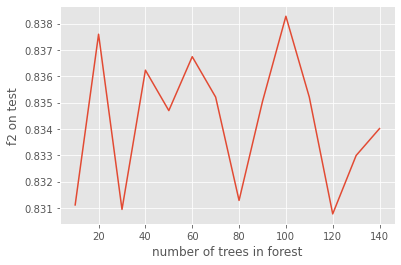

In [43]:
N = []
f2 = []

for n in np.arange(10, 150, 10):
    rf = RandomForestClassifier(n_estimators = 5)

    rf.fit(train_x, train_y)

    pred_rf = rf.predict(test_x)
    N.append(n)
    f2.append(f1_score(test_y,  pred_rf, average='micro'))

plt.plot(N, f2, '-')
plt.xlabel('number of trees in forest')
plt.ylabel('f2 on test')

In [44]:
f_imp_list1 = list(zip(N, f2))
f_imp_list1.sort(key = lambda x: x[1], reverse=True)
f_imp_list1[:5]

[(100, 0.8382804503582395),
 (20, 0.8375980893892869),
 (60, 0.8367451381780963),
 (40, 0.8362333674513818),
 (70, 0.8352098259979529)]

In [45]:
parameters = {'max_depth' : np.arange(2, 100, 4),
          'max_features' : ['sqrt', 'log2', None],
          'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
          'min_samples_leaf' : [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
          }
xlf = RandomForestClassifier(n_estimators=100)
cv = RandomizedSearchCV(estimator = xlf, param_distributions=parameters, scoring = f1, n_iter = 80, cv=3, n_jobs = -1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

{'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 18}
0.8635433426866109


In [46]:
best_model = RandomForestClassifier(n_estimators=100, max_depth = 18, min_samples_split = 12, min_samples_leaf =2, max_features = "sqrt")
best_model.fit(train_x, train_y)
prediction = best_model.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8648925281473899

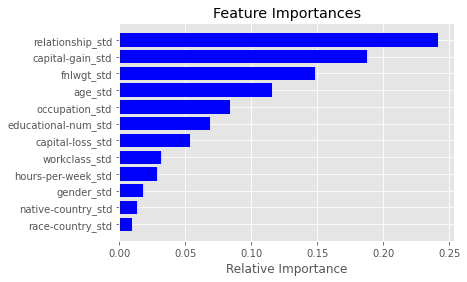

In [47]:
features = train_x.columns
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [48]:
f_imp_list2 = list(zip(features, best_model.feature_importances_))
f_imp_list2.sort(key = lambda x: x[1], reverse=True)
f_imp_list2[:10]

[('relationship_std', 0.2414980291735583),
 ('capital-gain_std', 0.18788325920436785),
 ('fnlwgt_std', 0.14793504623163814),
 ('age_std', 0.11562829605488811),
 ('occupation_std', 0.08411492726145992),
 ('educational-num_std', 0.06886700995321812),
 ('capital-loss_std', 0.05317768503332839),
 ('workclass_std', 0.03179839941175583),
 ('hours-per-week_std', 0.02843793741530411),
 ('gender_std', 0.01765147584521081)]

## Catboost

In [ ]:
parameters = {
              'depth': [1, 4, 7, 10, 13, 16, 19],
              'learning_rate': [0.03, 0.1, 0.15, 0.3, 0.9],
              'l2_leaf_reg': [1, 3, 5, 7, 9, 11],
              'iterations': [100, 200, 300, 400, 500]}
label_ratio = (y==1).sum()/(y==0).sum()
cb = cb.CatBoostClassifier(scale_pos_weight = label_ratio, logging_level='Silent')          
cv = RandomizedSearchCV(estimator = cb, scoring = f1, param_distributions=parameters, n_iter = 90, cv=3, n_jobs = -1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

## XGBOOST

In [56]:
clf_1 = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=(y.value_counts()[0]/y.value_counts()[1])).fit(train_x, train_y)
prediction = clf_1.predict(test_x)
f1_score(test_y, prediction, average='micro')

0.8357215967246674

In [ ]:
parameters = {
              'max_depth': [5, 10, 15, 20, 25],
              'learning_rate': [0.01, 0.05, 0.1, 0.15],
              'n_estimators': [500, 1000, 2000, 3000, 5000],
              'min_child_weight': [1, 5, 15, 200],
              'subsample': [0.6, 0.8, 0.95],
              'colsample_bytree': [0.5, 0.7, 0.9], 
}
xlf = xgboost.XGBClassifier(objective = "binary:logistic", scale_pos_weight=(y.value_counts()[0]/y.value_counts()[1]))        
cv = RandomizedSearchCV(estimator = xlf, param_distributions=parameters, n_iter = 80, cv=3, n_jobs = -1, scoring = f1)
cv.fit(train_x, train_y)    
print(cv.best_params_)
print(cv.best_score_)

In [ ]:
f_imp_list = list(zip(train_x.columns, cv.feature_importances_))
f_imp_list.sort(key = lambda x: x[1], reverse=True)
f_imp_list[:5]

## Pytorch

In [49]:
import torch
import random
import numpy as np
random.seed(0) 
np.random.seed(0) 
torch.manual_seed(0) 

In [50]:
train_X = train_x.to_numpy ()
test_X = test_x.to_numpy ()
train_Y = train_y.to_numpy ()
test_Y = test_y.to_numpy ()
X_train = torch.FloatTensor(train_X) 
X_test = torch.FloatTensor(test_X) 
y_train = torch.LongTensor(train_Y)
y_test = torch.LongTensor(test_Y)

In [54]:
class RichNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(RichNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(12, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 1) 
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x

    
model = RichNet(5)

In [55]:
from torch import nn
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=1.0e-2)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

def learn_binary_classification_model(model, n_epochs, print_every_epoch=None):
    if print_every_epoch is None:
        print_every_epoch = n_epochs / 100
    torch.manual_seed(42)

    for epoch in range(n_epochs):
        ### Обучение
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits)) 

        loss = loss_fn(y_logits,
                       y_train.float()) 
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred) 

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        model.eval()
        with torch.inference_mode():
      
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
     
            test_loss = loss_fn(test_logits,
                                y_test.float())
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)

      
        if epoch % print_every_epoch == 0:
            print(f"Epoch: {epoch:3} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    
    
learn_binary_classification_model(model, 5000)

Epoch:   0 | Loss: 0.59303, Accuracy: 76.05% | Test loss: 0.58648, Test acc: 76.05%
Epoch:  50 | Loss: 0.49531, Accuracy: 76.05% | Test loss: 0.49297, Test acc: 76.05%
Epoch: 100 | Loss: 0.41239, Accuracy: 82.03% | Test loss: 0.40996, Test acc: 82.89%
Epoch: 150 | Loss: 0.39244, Accuracy: 83.27% | Test loss: 0.38839, Test acc: 83.88%
Epoch: 200 | Loss: 0.37595, Accuracy: 83.37% | Test loss: 0.37168, Test acc: 84.12%
Epoch: 250 | Loss: 0.35924, Accuracy: 83.53% | Test loss: 0.35722, Test acc: 84.17%
Epoch: 300 | Loss: 0.34759, Accuracy: 83.84% | Test loss: 0.34752, Test acc: 84.32%
Epoch: 350 | Loss: 0.34239, Accuracy: 84.01% | Test loss: 0.34225, Test acc: 84.41%
Epoch: 400 | Loss: 0.33964, Accuracy: 84.01% | Test loss: 0.34007, Test acc: 84.31%
Epoch: 450 | Loss: 0.33731, Accuracy: 84.13% | Test loss: 0.33855, Test acc: 84.25%
Epoch: 500 | Loss: 0.33562, Accuracy: 84.25% | Test loss: 0.33731, Test acc: 84.56%
Epoch: 550 | Loss: 0.33436, Accuracy: 84.29% | Test loss: 0.33638, Test acc: